In [3]:

import os, sys, json
import uuid
from datetime import date

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import streamlit as st
from streamlit_option_menu import option_menu
import hydralit_components as hc

from st_aggrid import AgGrid
from st_aggrid.grid_options_builder import GridOptionsBuilder
import plotly.express as px

from palettable.scientific.sequential import Devon_20
import colour
from colour import Color

this_dir = os.getcwd()
repo_root_dir = this_dir.split("qc-repo")[0] + 'qc-repo/'

sys.path.append(os.path.abspath(repo_root_dir + 'simulating-quantum-systems/'))


from helpers.data_helpers import *
from _app_parms import *

load_environ(repo_root_dir + "simulating-quantum-systems/db_creds.env")

postgres_conn = get_postgres_conn()



Connected to version: PostgreSQL 13.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit


## Example Seaborn Heatmap Plot

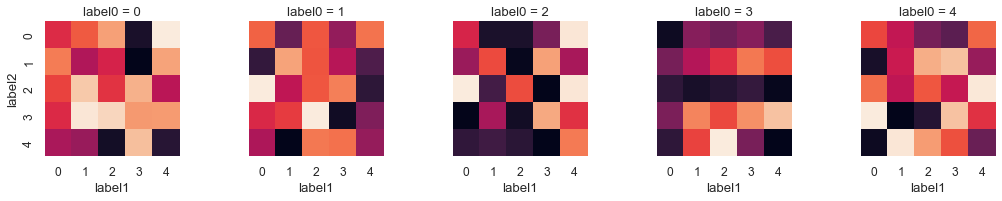

In [180]:

# Generate a set of sample data
np.random.seed(0)
indices = pd.MultiIndex.from_product((range(5), range(5), range(5)), names=('label0', 'label1', 'label2'))

data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)), index=indices, columns=('value',)).reset_index()

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(data, col='label0')
fg.map_dataframe(draw_heatmap, 'label1', 'label2', 'value', cbar=False, square = True)
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal','box')
plt.show()

## Example Plotly Heatmap

In [232]:
import numpy as np
import pandas as pd
import plotly.express

# Generate a set of sample data
np.random.seed(0)
indices = pd.MultiIndex.from_product((range(5), range(5), range(5)), names=('label0', 'label1', 'label2'))
data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)), index=indices, columns=('value',)).reset_index()

# plotly.graph_objects Heatmap showscale
import plotly.graph_objects as go
from plotly.subplots import make_subplots

titles = ['label0='+ str(x) for x in range(5)]
fig = make_subplots(rows=1, cols=len(data['label0'].unique()),
                    shared_yaxes=True,
                    subplot_titles = tuple(titles))

for i in data['label0'].unique():
    df = data[data['label0'] == i]
    #colorbar=dict(orientation='h'), 
    fig.add_trace(go.Heatmap(z=df.value, x=df.label1, y=df.label2, coloraxis = "coloraxis"), row=1, col=i+1)
    fig.update_xaxes(dtick=[0,1,2,3,4])
    fig.update_xaxes(title_text='label1', row=1, col=i+1)
    fig.update_yaxes(title_text='label2', row=1, col=1)
    fig.update_layout(height=300, width=800)

#fig.update_traces(showscale=True)
fig.data[0]["showscale"] = True
#fig.data[1]["showscale"] = False
#fig.data[2]["showscale"] = False
#fig.data[3]["showscale"] = False

fig.show()

In [4]:
experiment_metadata_df = get_table(conn = postgres_conn, table_name = experiments_metadata_cplc_table_name, schema_name = core_schema)
experiment_metadata_df.head()

SQL Statement: select  *  from quantumlab_experiments.experiments_metadata_jwcplc 


,experiment_id,experiment_run_date,status,experiment_name,experiment_description,num_qubit_space,n_simulations,p_space,q_space,use_constant_size,constant_size,subsystem_range_divider,runtime_in_seconds,experimental_design_type
0,0xc1bda278887040a28f92c5ec9b0315bb,05-19-2022,Completed,Testing jwcplc,Testing jwcplc,"6,8,10",100,"0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9","0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9",False,3,0.5,622.0,Jordan-Wigner CPLC
1,0x06dfa27044774ab7b9c9c484304846d1,05-19-2022,Completed,Testing jwcplc - bigger systems,Testing jwcplc - bigger systems,"10,12,14,16,18,20",100,"0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9","0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9",False,3,0.5,4951.0,Jordan-Wigner CPLC
2,0x256d038b432d44b5aea0a12f156d08dc,05-20-2022,Running,Testing jwcplc - bigger systems & more granula...,Testing jwcplc - bigger systems & more granula...,"10,12,14,16,18,20",50,"0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0...","0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0...",False,3,0.5,0.0,Jordan-Wigner CPLC


In [247]:
experiment_id = '0x256d038b432d44b5aea0a12f156d08dc'# '0x06dfa27044774ab7b9c9c484304846d1'# '0xc1bda278887040a28f92c5ec9b0315bb'
experiment_results_df = get_table(conn = postgres_conn, table_name = simulation_results_cplc_table_name, schema_name = core_schema, where_string = " where experiment_id = '"+experiment_id + "'")
experiment_results_df['num_qubits'] = experiment_results_df.num_qubits.astype(str)
experiment_results_df['mean_runtime_min'] = experiment_results_df['mean_runtime'].apply(lambda x: x/60)

experiment_results_df.head()



SQL Statement: select  *  from quantumlab_experiments.simulation_results_jwcplc  where experiment_id = '0x256d038b432d44b5aea0a12f156d08dc'


,num_qubits,p,q,mean_entropy,se_mean_entropy,experiment_id,mean_runtime,mean_runtime_min
0,10,0.1,0.10,0.110904,0.036302,0x256d038b432d44b5aea0a12f156d08dc,0.03572,0.000595
1,10,0.1,0.15,0.138629,0.039608,0x256d038b432d44b5aea0a12f156d08dc,0.02924,0.000487
2,10,0.1,0.20,0.249533,0.047530,0x256d038b432d44b5aea0a12f156d08dc,0.02822,0.000470
3,10,0.1,0.25,0.152492,0.041019,0x256d038b432d44b5aea0a12f156d08dc,0.02850,0.000475
4,10,0.1,0.30,0.332711,0.049471,0x256d038b432d44b5aea0a12f156d08dc,0.02936,0.000489


In [6]:
n_qubits = len(experiment_results_df.num_qubits.unique())
n_simulations = experiment_metadata_df.n_simulations.values[0]

n_qubit_color_palette = list(Color("#3f007d").range_to(Color("#dadaeb"),n_qubits))
n_qubit_color_palette = np.flip([c.hex for c in n_qubit_color_palette])


In [7]:
pd.set_option('display.max_rows', None)

experiment_results_df_plot_eg = experiment_results_df[experiment_results_df.num_qubits=='6']
experiment_results_df_plot_eg = experiment_results_df_plot_eg[['p','q','mean_entropy']]
experiment_results_df_plot_eg

,p,q,mean_entropy


In [8]:
experiment_results_df.num_qubits.unique()

array(['10', '12', '14', '16', '18', '20'], dtype=object)

In [9]:
experiment_results_df_plot_eg_wide = experiment_results_df_plot_eg.pivot(index="q", columns="p", values="mean_entropy")
experiment_results_df_plot_eg_wide.head()

p
q


In [10]:
facet_plot_eg = experiment_results_df[['num_qubits','p','q','mean_entropy']]

In [182]:
facet_plot_eg["num_qubits"] = pd.to_numeric(facet_plot_eg["num_qubits"])

/var/folders/ll/ncs54ns51dvc_v__m6s7brh40000gn/T/ipykernel_89795/1603399311.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
facet_plot_eg.sort_values(["num_qubits", "p", "q"], ascending = [True, True, True], inplace = True)
facet_plot_eg.head()

/Users/mercicle/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,num_qubits,p,q,mean_entropy
0,10,0.1,0.10,0.110904
1,10,0.1,0.15,0.138629
2,10,0.1,0.20,0.249533
3,10,0.1,0.25,0.152492
4,10,0.1,0.30,0.332711


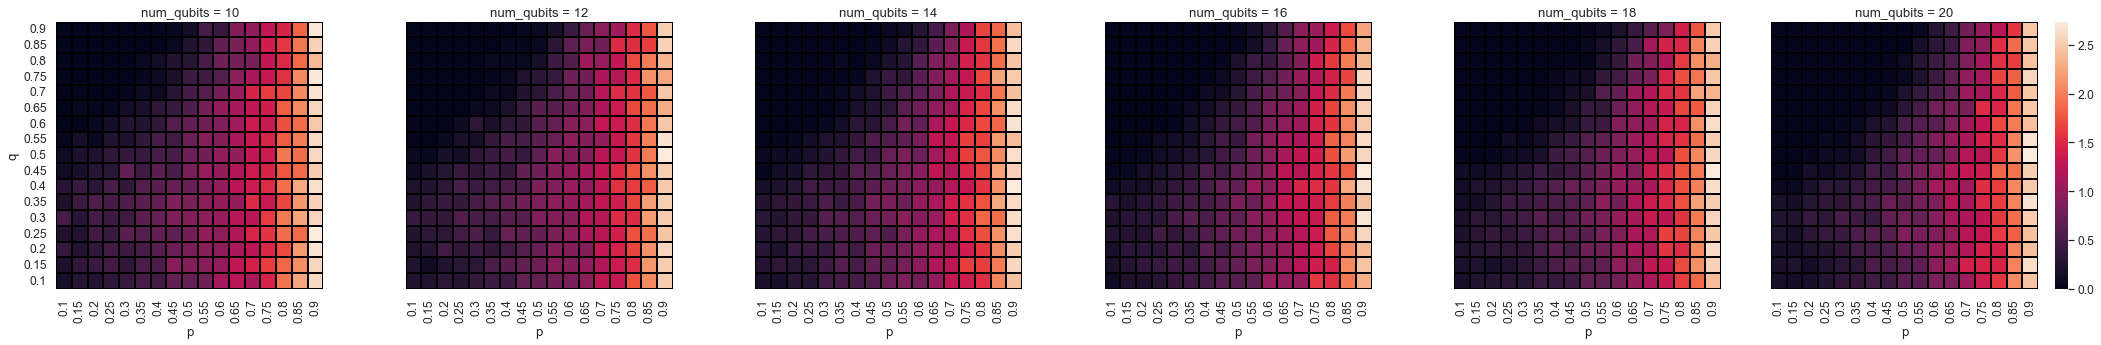

In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

col_wrap_max = 6
plot_index = 1
#https://stackoverflow.com/questions/41471238/how-to-make-heatmap-square-in-seaborn-facetgrid
def draw_heatmap(*args, **kwargs):
    global plot_index
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_index.html
    d.sort_index(axis=0,ascending=False, inplace=True)
    
    if plot_index == col_wrap_max:
        h = sns.heatmap(d, **kwargs, cbar=True)
    else:
        h = sns.heatmap(d, **kwargs, cbar=False)

    #h.set_xticklabels(h.get_xmajorticklabels(), fontsize = 16)
    plot_index +=1

# https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
fig = sns.FacetGrid(facet_plot_eg, col='num_qubits',height=5, aspect=1,col_wrap=col_wrap_max)
sns.set(font_scale=1.1)
fig.map_dataframe(draw_heatmap, 'p', 'q', 'mean_entropy', cbar_kws={'orientation': 'vertical'}, square = True,linewidths=1, linecolor='black')
for ax in fig.axes.flat:
    ax.set_aspect('equal','box')
#plt.show()
plt.savefig('jw_cplc_heatmaps_'+ experiment_id +'.pdf')


In [55]:
facet_plot_eg['p'] = facet_plot_eg['p'].astype(str)
facet_plot_eg['q'] = facet_plot_eg['q'].astype(str)
facet_plot_eg['num_qubits'] = facet_plot_eg['num_qubits'].astype(str)


/var/folders/ll/ncs54ns51dvc_v__m6s7brh40000gn/T/ipykernel_89795/2155602118.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ll/ncs54ns51dvc_v__m6s7brh40000gn/T/ipykernel_89795/2155602118.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ll/ncs54ns51dvc_v__m6s7brh40000gn/T/ipykernel_89795/2155602118.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [91]:
facet_plot_eg['num_qubits'].unique()

array(['10', '12', '14', '16', '18', '20'], dtype=object)

In [234]:
import numpy as np
import pandas as pd
import plotly.express
import plotly.graph_objects as go
from plotly.subplots import make_subplots

max_columns = 4
max_rows = int(np.ceil(len(facet_plot_eg['num_qubits'].unique())/max_columns))
titles = ['Qubits='+ str(x) for x in facet_plot_eg['num_qubits'].unique().astype(str)]
fig = make_subplots(rows=max_rows, cols=max_columns,
                    shared_yaxes=True,
                    subplot_titles = tuple(titles))

In [236]:
i_index = 1
max_index = len(facet_plot_eg['num_qubits'].unique())
for i in facet_plot_eg['num_qubits'].unique():
    
    df = facet_plot_eg[facet_plot_eg['num_qubits'] == i]
    row_index = int(np.floor(i_index/(max_columns+1))+1)
    col_index = i_index % max_columns
    
    #print("i_index: "+ str(i_index)+" "+" row_index: "+ str(row_index)+" "+" col_index: "+ str(col_index)+" ")

    if col_index == 0:
        col_index = max_columns
    #print("i_index: "+ str(i_index)+" "+" row_index: "+ str(row_index)+" "+" col_index: "+ str(col_index)+" ")
        
    fig.add_trace(go.Heatmap(z=df.mean_entropy, x=df.p, y=df.q,showscale = True, hoverinfo='text', hovertemplate='p: %{x}<br>q: %{y}<br>Mean Entropy: %{z}<extra></extra>'), row=row_index, col=col_index)
    
    #dtick=list(facet_plot_eg['p'].unique())
    fig.update_xaxes(title_text='p', row=row_index, col=col_index)
    fig.update_yaxes(title_text='q', row=row_index, col=col_index)

    #if i_index == max_index:
    #    fig.update_traces(xgap=1,ygap=1,showscale = True)
    #else:
    #    fig.update_traces(xgap=1,ygap=1,showscale = False)

    fig.update_layout(plot_bgcolor='black',height=800, width=900)
    fig.update_xaxes(showline=True, linewidth=0.75, linecolor='black', gridcolor='black')
    fig.update_yaxes(showline=True, linewidth=0.75, linecolor='black', gridcolor='black')
    i_index+=1

#fig.update_layout(showlegend=False,)
fig.update_traces(xgap=1,ygap=1,showscale = False)
fig.show()

In [258]:
facet_plot_runtime_df = experiment_results_df[['num_qubits','p','q','mean_runtime_min']]
facet_plot_runtime_df = facet_plot_runtime_df[~facet_plot_runtime_df.p.isin([0.10,0.90]) & ~facet_plot_runtime_df.q.isin([0.10])]

In [259]:
max_columns = 3
heatmap_grid_height = 600
heatmap_grid_width = 1000

max_rows = int(np.ceil(len(facet_plot_runtime_df['num_qubits'].unique())/max_columns))
titles = ['Qubits='+ str(x) for x in facet_plot_runtime_df['num_qubits'].unique().astype(str)]

fig = make_subplots(rows=max_rows, cols=max_columns,
                    shared_yaxes=True,
                    subplot_titles = tuple(titles))

i_index = 1
max_index = len(facet_plot_runtime_df['num_qubits'].unique())
for i in facet_plot_runtime_df['num_qubits'].unique():

    df = facet_plot_runtime_df[facet_plot_runtime_df['num_qubits'] == i]
    row_index = int(np.floor(i_index/(max_columns+1))+1)
    col_index = i_index % max_columns

    #print("i_index: "+ str(i_index)+" "+" row_index: "+ str(row_index)+" "+" col_index: "+ str(col_index)+" ")

    if col_index == 0:
        col_index = max_columns
    #print("i_index: "+ str(i_index)+" "+" row_index: "+ str(row_index)+" "+" col_index: "+ str(col_index)+" ")

    fig.add_trace(go.Heatmap(z=df.mean_runtime_min, x=df.p, y=df.q, hoverinfo='text', hovertemplate='p: %{x}<br>q: %{y}<br>Mean Simulation Runtime: %{z}<extra></extra>'), row=row_index, col=col_index)

    #dtick=list(facet_plot_eg['p'].unique())
    fig.update_xaxes(title_text='p', row=row_index, col=col_index)
    fig.update_yaxes(title_text='q', row=row_index, col=col_index)

    #if i_index == max_index:
    #    fig.update_traces(xgap=1,ygap=1,showscale = True)
    #else:
    #    fig.update_traces(xgap=1,ygap=1,showscale = False)

    fig.update_layout(plot_bgcolor='black',height=heatmap_grid_height, width=heatmap_grid_width)
    fig.update_xaxes(showline=True, linewidth=0.75, linecolor='black', gridcolor='black')
    fig.update_yaxes(showline=True, linewidth=0.75, linecolor='black', gridcolor='black')
    i_index+=1

#fig.update_layout(showlegend=False,)
fig.update_traces(xgap=1,ygap=1,showscale = False)

In [255]:
facet_plot_runtime_df.p

0       0.10
1       0.10
2       0.10
3       0.10
4       0.10
5       0.10
6       0.10
7       0.10
8       0.10
9       0.10
10      0.10
11      0.10
12      0.10
13      0.10
14      0.10
15      0.10
16      0.10
17      0.15
18      0.15
19      0.15
20      0.15
21      0.15
22      0.15
23      0.15
24      0.15
25      0.15
26      0.15
27      0.15
28      0.15
29      0.15
30      0.15
31      0.15
32      0.15
33      0.15
34      0.20
35      0.20
36      0.20
37      0.20
38      0.20
39      0.20
40      0.20
41      0.20
42      0.20
43      0.20
44      0.20
45      0.20
46      0.20
47      0.20
48      0.20
49      0.20
50      0.20
51      0.25
52      0.25
53      0.25
54      0.25
55      0.25
56      0.25
57      0.25
58      0.25
59      0.25
60      0.25
61      0.25
62      0.25
63      0.25
64      0.25
65      0.25
66      0.25
67      0.25
68      0.30
69      0.30
70      0.30
71      0.30
72      0.30
73      0.30
74      0.30
75      0.30
76      0.30